In [ ]:
!pip install transformers
!pip install accelerate
!pip install peft
!pip install datasets
!pip install evaluate
!pip install bitsandbytes
!pip install wandb

In [ ]:
from datasets import load_dataset
dataset = load_dataset("pile-of-law/pile-of-law",'r_legaladvice')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for pile-of-law/pile-of-law contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/pile-of-law/pile-of-law
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datas

In [ ]:
from datasets import Dataset
import pandas as pd
train_eval_dataset = dataset['train']
train_eval_dataset_df = train_eval_dataset.to_pandas()
train_eval_dataset_df = train_eval_dataset_df.sample(frac=1)
train_eval_dataset_df = pd.DataFrame.from_dict(train_eval_dataset[:int(0.4*len(train_eval_dataset_df))])
train_eval_dataset = Dataset.from_pandas(train_eval_dataset_df)

train_eval_dataset_split = train_eval_dataset.train_test_split(test_size=0.2)
train_dataset = train_eval_dataset_split['train']
eval_dataset = train_eval_dataset_split['test']
test_datset = dataset['validation']

In [ ]:
test_dataset_df = test_datset.to_pandas()
test_dataset_df = test_dataset_df.sample(frac=1)[:10000]
test_datset = Dataset.from_dict(test_dataset_df)

In [ ]:
train_dataset

Dataset({
    features: ['text', 'created_timestamp', 'downloaded_timestamp', 'url'],
    num_rows: 35116
})

In [ ]:
from transformers import AutoTokenizer,AutoModelForCausalLM,BitsAndBytesConfig
import torch
model_path = 'mistralai/Mistral-7B-v0.1'
tokenizer = AutoTokenizer.from_pretrained(model_path, token=os.environ['ACCESS_TOKEN'])

In [ ]:
def find_substrings_after(original, delimiter):
    # Return the substring after the delimiter if present, else return the original text
    start_idx = original.find(delimiter) + len(delimiter) if delimiter in original else 0
    return original[start_idx:].strip()

from tqdm import tqdm
def pre_processing(df):
  df_dict = df.to_dict(orient='list')
  df_dict['Question'] = []
  df_dict['Answer'] = []
  for i in tqdm(range(len(df_dict['text']))):
    text = df_dict['text'][i]
    question = find_substrings_after(text, 'Title:')
    answer = find_substrings_after(text, 'Answer #1:')
    df_dict['Question'].append(question)
    df_dict['Answer'].append(answer)
  df = pd.DataFrame(df_dict)
  return df

In [ ]:
import pandas as pd
train_df = train_dataset.to_pandas()
train_df = pre_processing(train_df)
eval_df = eval_dataset.to_pandas()
eval_df = pre_processing(eval_df)
test_df = test_datset.to_pandas()
test_df = pre_processing(test_df)

100%|██████████| 10000/10000 [00:00<00:00, 150437.00it/s]


In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_dict(train_df.to_dict(orient='list'))
eval_dataset = Dataset.from_dict(eval_df.to_dict(orient='list'))
test_dataset = Dataset.from_dict(test_df.to_dict(orient='list'))

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
df = train_dataset.to_pandas()
df.head()

,text,created_timestamp,downloaded_timestamp,url,Question,Answer
0,Title: [OH] I work for a non-profit catering c...,01-27-2014,11-11-2021,http://www.reddit.com/r/legaladvice/comments/1...,"[OH] I work for a non-profit catering company,...","Yep, it's illegal for employers to keep tips. ..."
1,Title: [Louisiana USA] After hospital stay I w...,04-07-2016,11-10-2021,https://www.reddit.com/r/legaladvice/comments/...,[Louisiana USA] After hospital stay I was neve...,Call your insurance company and see if they ha...
2,"Title: [Philadelphia, PA] Locks for apartment ...",09-06-2018,09-29-2021,https://www.reddit.com/r/legaladvice/comments/...,"[Philadelphia, PA] Locks for apartment bedroom...",There are portable door jambs that sit on the ...
3,Title: [CA] My landlord had a conservator take...,02-16-2016,11-10-2021,https://www.reddit.com/r/legaladvice/comments/...,[CA] My landlord had a conservator take over h...,3 days is a no way. unless you owe tons of ren...
4,Title: Hypothetical: If I’m smoking marijuana ...,09-10-2018,11-12-2021,https://www.reddit.com/r/legaladviceofftopic/c...,Hypothetical: If I’m smoking marijuana and som...,"Regadless of state law, under federal law an h..."


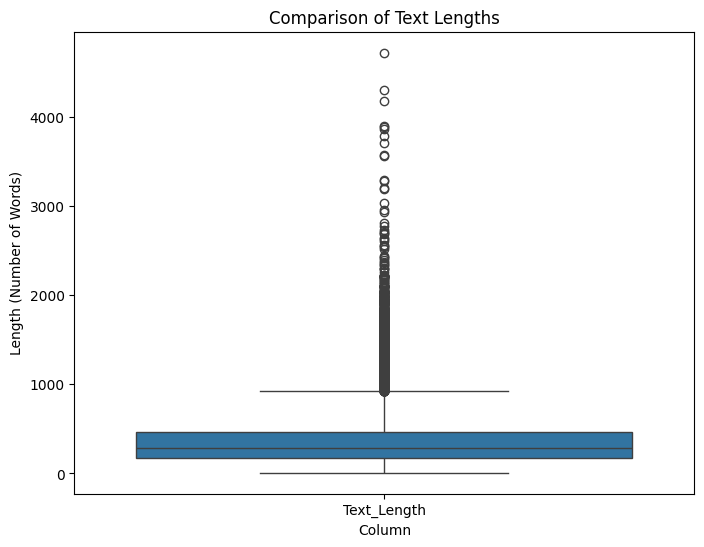

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named 'df' and has 'Text' and 'Summary' columns

# Calculate the lengths of the text and summary
df['Text_Length'] = df['text'].apply(lambda x: len(x.split()))
#df['Summary_Length'] = df['Summary'].apply(lambda x: len(x.split()))

# Melt the DataFrame to convert it into a long format
df_melted = pd.melt(df[['Text_Length']], var_name='Column', value_name='Length')

# Create a boxplot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Column', y='Length', data=df_melted)
plt.title('Comparison of Text Lengths')
plt.xlabel('Column')
plt.ylabel('Length (Number of Words)')
plt.show()

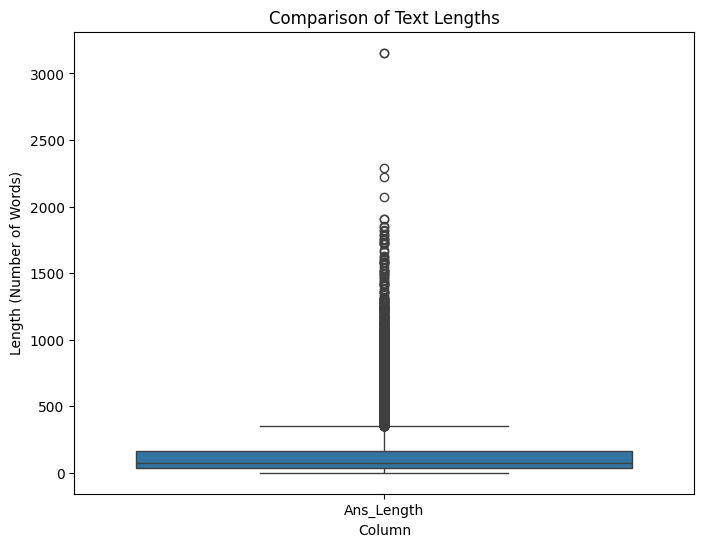

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named 'df' and has 'Text' and 'Summary' columns

# Calculate the lengths of the text and summary
df['Ans_Length'] = df['Answer'].apply(lambda x: len(x.split()))
#df['Summary_Length'] = df['Summary'].apply(lambda x: len(x.split()))

# Melt the DataFrame to convert it into a long format
df_melted = pd.melt(df[['Ans_Length']], var_name='Column', value_name='Length')

# Create a boxplot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Column', y='Length', data=df_melted)
plt.title('Comparison of Text Lengths')
plt.xlabel('Column')
plt.ylabel('Length (Number of Words)')
plt.show()

In [ ]:
def tokenize_function(examples):
  prompt = [f"Generate-Legal Advice: {examples['Question'][i]}+Answer: {examples['Answer'][i]}" for i in range(len(examples['text']))]
  result = {'input_ids':[],'attention_mask':[],'labels':[]}
  for i in range(len(prompt)):
    res = tokenizer(prompt[i],
            truncation=True,
            max_length=512,
            padding=False,
            add_special_tokens=False)
    result['labels'].append(res['input_ids'].copy())
    result['input_ids'].append(res['input_ids'])
    result['attention_mask'].append(res['attention_mask'])

  return result
train_tokenized_dataset = train_dataset.map(tokenize_function,
                                batched=True,
                                remove_columns=["text","created_timestamp","downloaded_timestamp","url"])
eval_tokenized_dataset = eval_dataset.map(tokenize_function,
                                batched=True,
                                remove_columns=["text","created_timestamp","downloaded_timestamp","url"])
test_tokenized_dataset = test_dataset.map(tokenize_function,
                                batched=True,
                                remove_columns=["text","created_timestamp","downloaded_timestamp","url"])


Map:   0%|          | 0/35116 [00:00<?, ? examples/s]

Map:   0%|          | 0/8780 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# def tokenize_function(examples):
#     questions = examples['Question']
#     answers = examples['Answer']

#     prompt = [f"Question: {question}, Answer: {answer}" for question, answer in zip(questions, answers)]

#     model_inputs = tokenizer(prompt, max_length=750, truncation=True, padding="max_length")

#     question_tokens = tokenizer(f"Question: {questions[0]}, Answer:", add_special_tokens=False)["input_ids"]
#     answer_tokens = tokenizer(answers, max_length=750, truncation=True, padding="max_length", add_special_tokens=False)["input_ids"]

#     labels = [[-100] * len(question_tokens) + a_tokens + [-100] * (750 - len(question_tokens) - len(a_tokens)) for a_tokens in answer_tokens]

#     model_inputs['labels'] = labels

#     return model_inputs

In [ ]:
block_size = 512
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
 k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result


In [ ]:
train_tokenized_dataset = train_tokenized_dataset.remove_columns(['Question','Answer'])
eval_tokenized_dataset = eval_tokenized_dataset.remove_columns(['Question','Answer'])
test_tokenized_dataset = test_tokenized_dataset.remove_columns(['Question','Answer'])

In [ ]:
train_tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 87792
})

In [ ]:
train_lm_datasets = train_tokenized_dataset.map(
    group_texts,
    batched=True,
)
eval_lm_datasets = eval_tokenized_dataset.map(
    group_texts,
    batched=True,
)
test_lm_datasets = test_tokenized_dataset.map(
    group_texts,
    batched=True,
)

Map:   0%|          | 0/35116 [00:00<?, ? examples/s]

Map:   0%|          | 0/8780 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
train_tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
train_lm_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_lm_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_lm_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
print(len(train_lm_datasets))
print(len(eval_lm_datasets))
print(len(test_lm_datasets))

25075
6269
26352


In [ ]:
print(train_lm_datasets['input_ids'][0].shape)
print(train_lm_datasets['labels'][0].shape)

torch.Size([512])
torch.Size([512])


In [ ]:
from peft import prepare_model_for_kbit_training
from peft import LoraConfig,TaskType
from peft import get_peft_model
lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model_path = 'mistralai/Mistral-7B-v0.1'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    trust_remote_code=True,
    token=os.environ['ACCESS_TOKEN'],
    quantization_config=bnb_config,
)
#model = prepare_model_for_kbit_training(model)
peft_model = get_peft_model(model,lora_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def get_target_modules(model):
    target_modules = set()
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            target_modules.add(name)
    return list(target_modules)

target_modules = get_target_modules(model)
target_modules

['model.layers.18.self_attn.o_proj',
 'model.layers.10.mlp.up_proj',
 'model.layers.10.self_attn.o_proj',
 'model.layers.29.self_attn.v_proj',
 'model.layers.14.mlp.up_proj',
 'model.layers.8.self_attn.v_proj',
 'model.layers.13.self_attn.o_proj',
 'model.layers.8.self_attn.q_proj',
 'model.layers.23.mlp.down_proj',
 'model.layers.6.mlp.up_proj',
 'model.layers.12.self_attn.v_proj',
 'model.layers.14.self_attn.q_proj',
 'model.layers.27.mlp.up_proj',
 'model.layers.2.self_attn.q_proj',
 'model.layers.4.self_attn.v_proj',
 'model.layers.15.mlp.gate_proj',
 'model.layers.31.mlp.down_proj',
 'model.layers.7.self_attn.q_proj',
 'model.layers.29.mlp.up_proj',
 'model.layers.27.self_attn.v_proj',
 'model.layers.8.mlp.down_proj',
 'model.layers.11.mlp.up_proj',
 'model.layers.7.self_attn.k_proj',
 'model.layers.30.mlp.gate_proj',
 'model.layers.3.mlp.up_proj',
 'model.layers.10.self_attn.k_proj',
 'model.layers.9.mlp.down_proj',
 'model.layers.19.self_attn.o_proj',
 'model.layers.26.self_attn

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType
lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["k_proj","v_proj"],
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM
)
peft_model = get_peft_model(model,lora_config)

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling, DefaultDataCollator,DataCollatorForSeq2Seq
data_collator = data_collator=DataCollatorForLanguageModeling(tokenizer,mlm=False)

In [ ]:
tr_dataset = train_lm_datasets.train_test_split(test_size=0.1)
tr_dataset_split = tr_dataset['test'].shuffle(seed=42).train_test_split(test_size=0.3)

tr_lm_dataset = tr_dataset_split['train']
ev_lm_dataset = tr_dataset_split['test']

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup,AdamW
import datetime

current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f'MistalFineTune_7_{current_time}'

training_args = TrainingArguments(
    report_to='wandb',
    output_dir='trial_classification',
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    evaluation_strategy='epoch',
    learning_rate=1e-5,
    logging_steps=50,
    warmup_steps=500,
    weight_decay=0.001,
    dataloader_num_workers=2,
    fp16=True,
    eval_accumulation_steps=1,
    run_name=run_name,
)
# optimizer = AdamW(peft_model.parameters(), lr=training_args.learning_rate)

# # Calculate the total number of training steps
# total_steps = (len(tr_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)) * training_args.num_train_epochs

# # Create the learning rate scheduler
# lr_scheduler = get_linear_schedule_with_warmup(
#     optimizer=optimizer,
#     num_warmup_steps=training_args.warmup_steps,
#     num_training_steps=total_steps,
# )

# Create the trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_lm_datasets,
    eval_dataset=eval_lm_datasets,
)

In [ ]:
# !wandb cache clear
# !wandb login --relogin
trainer.train()

wandb: Currently logged in as: devansh20053 (devansh2002). Use `wandb login --relogin` to force relogin


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:581: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-6626e012-0c9ba28143f71e220608ff57;d65ed293-2493-4da6-8f16-6f52580f676d)

Cannot access gated repo for url https://huggingface.co/mistralai/Mistral-7B-v0.1/resolve/main/config.json.
Repo model mistralai/Mistral-7B-v0.1 is gated. You must be authenticated to access it. - silently ignoring the lookup for the file config.json in mistralai/Mistral-7B-v0.1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in mistralai/Mistral-7B-v0.1 - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:581: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-6626e191-3bd878453b3b83926e8c33c2;f00439a0-aae7-4543-8dac-bd7d5b0205f4)

C

Epoch,Training Loss,Validation Loss
1,1.929600,1.929763
2,1.895800,1.928080


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:581: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-6626e30f-0f99645a72f24c8b6de82cf5;384c2c41-fca1-45ad-9b37-a944b14bcf81)

Cannot access gated repo for url https://huggingface.co/mistralai/Mistral-7B-v0.1/resolve/main/config.json.
Repo model mistralai/Mistral-7B-v0.1 is gated. You must be authenticated to access it. - silently ignoring the lookup for the file config.json in mistralai/Mistral-7B-v0.1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in mistralai/Mistral-7B-v0.1 - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:581: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-6626e48e-4309f688723f1a7b785d2e32;16b4507b-cd86-4cab-8cf9-f66d07e65860)

C

TrainOutput(global_step=14068, training_loss=1.9226673599126023, metrics={'train_runtime': 12245.6334, 'train_samples_per_second': 4.595, 'train_steps_per_second': 1.149, 'total_flos': 1.231515302190121e+18, 'train_loss': 1.9226673599126023, 'epoch': 2.0})

In [ ]:
from huggingface_hub import HfApi, HfFolder

api = HfApi()
api.create_repo(repo_id="legal-reddit-tuned", token=os.environ['ACCESS_TOKEN'], private=True) # Set `private=True` for a private repository
peft_model.push_to_hub("DevanshArora2002/legal-reddit-tuned", token=os.environ['ACCESS_TOKEN'])

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:581: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-66270e62-349e64985f91d2bb50decf3a;2a9c6b85-5810-4807-a552-2e92c81f1a0e)

Cannot access gated repo for url https://huggingface.co/mistralai/Mistral-7B-v0.1/resolve/main/config.json.
Repo model mistralai/Mistral-7B-v0.1 is gated. You must be authenticated to access it. - silently ignoring the lookup for the file config.json in mistralai/Mistral-7B-v0.1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in mistralai/Mistral-7B-v0.1 - will assume that the vocabulary was not modified.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/54.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DevanshArora2002/legal-reddit-tuned/commit/54556f0b164bdf1fc1ced3c38d077f431f760a84', commit_message='Upload model', commit_description='', oid='54556f0b164bdf1fc1ced3c38d077f431f760a84', pr_url=None, pr_revision=None, pr_num=None)